# Hearst Pattern Classifier

This Jupyter Notebook is broken up into several sections to complete the following tasks:

* Read in and clean $\textit{hearst_pattern_extraction.csv}$ data containing the labelled and unlabelled hypo/hypernym word pairs created from $\textit{Hearst.py}$.
* Load word embedding model and convert labelled word pairs into vectors of length 400.
* Train several classification models on the labelled data.
* Export proposed hypo/hypernym word pairs for SME scoring.
* Create graphs and tables for the final report.

## 1. Import Required Packages

In [1]:
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models import Phrases
import csv
import sys
import pandas as pd
from ast import literal_eval
import re
import sys
from sklearn import model_selection, naive_bayes, svm
import codecs
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt

C:\Users\Katie\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 2. Data Cleaning and Preparation

In [2]:
raw_hearst_patterns = pd.read_csv("../hearst_pattern_extraction.csv")
raw_hearst_patterns.head()

,index,randnum,hyponym,hypernym,tag,contains_relation,match,sentence
0,0,0.039061,the proper process,supervisory and management official on discipl...,NaN,NaN,"<re.Match object; span=(222, 232), match=', in...","under NP_the_authority, NP_direction, and NP_c..."
1,1,0.440877,procedure,supervisory and management official on discipl...,NaN,NaN,"<re.Match object; span=(222, 232), match=', in...","under NP_the_authority, NP_direction, and NP_c..."
2,2,0.860673,a write reprimand,a formal disciplinary action,NaN,NaN,"<re.Match object; span=(31, 40), match=' inclu...",NP_a_formal_disciplinary_action include NP_a_w...
3,3,0.998941,reference to previous counseling,the reason for selection of the penalty,NaN,NaN,"<re.Match object; span=(148, 158), match=', in...",guide by NP_the_Douglas_NP_factor outline in N...
4,4,0.928205,disciplinary action,the reason for selection of the penalty,NaN,NaN,"<re.Match object; span=(148, 158), match=', in...",guide by NP_the_Douglas_NP_factor outline in N...


In [3]:
# Ensure all data is lowercase for embedding model
raw_hearst_patterns["hyponym"] = raw_hearst_patterns["hyponym"].str.lower()
raw_hearst_patterns["hypernym"] = raw_hearst_patterns["hypernym"].str.lower()

In [4]:
# # Test case for simplifying the classification to binary rather than multiclass
# dictionary = {1: 0, 2: 1}
# raw_hearst_patterns["tag"] = raw_hearst_patterns["tag"].replace(dictionary)
# raw_hearst_patterns["tag"].unique()

In [5]:
# Separate labeled and unlabeled data
labeled_set = raw_hearst_patterns[["hyponym", "hypernym", "tag"]].dropna()
unlabeled_set = raw_hearst_patterns[["hyponym", "hypernym"]][raw_hearst_patterns[["hyponym", "hypernym", "tag"]].isna().values]

In [6]:
len(unlabeled_set)

13253

In [7]:
# Reading in more hypernyms from pickle
# with open("expanded_hypernyms.pkl", "rb") as file:
#     extra_data = pickle.load(file)

In [8]:
# len(extra_data)

In [9]:
# extra_data = extra_data[extra_data["relationship"] == "hypernym"].loc[:,["hyponym", "hypernym"]]
# print(len(extra_data))
# extra_data["hypernym"] = extra_data["hypernym"].str.lower()
# extra_data["hyponym"] = extra_data["hyponym"].str.lower()
# extra_data.head()

## 3. Created Word-Pair Embedding Vectors

In [10]:
model = KeyedVectors.load("custom_word_embeddings.bin")

In [11]:
X = labeled_set[["hyponym", "hypernym"]]
y = labeled_set["tag"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
X_train.head()

,hyponym,hypernym
612,focus area from the joint staff,the cbrn mcrs
6914,appointment of hipaa privacy,responsibility in this issuance
11776,operating building,facility
8811,cartridge,roll microform
2262,a rigorous system of internal review,mcsc


In [13]:
# Holds the word-pair embedding vectors
train_x = []

# Holds the indices to pull out the correct labels
x_indices = []

# Holds unmatched words to inspect for potential errors
unmatched = []

for i in range(len(X_train)-1):
    try:
        # Try to take the words as they are
        train_x.append(list(model[X_train.iloc[i,0]]) + list(model[X_train.iloc[i,1]]))
        x_indices.append(i)
    except:
        # Check if the first word has more than one word
        if len(X_train.iloc[i,0].split()) > 1:
            # If so, average the word embedding arrays
            word_list1 = X_train.iloc[i,0].split()
            try:
                vector_array1 = np.array([list(model[word]) for word in word_list1])
                final_array1 = list(np.average(vector_array1, axis=0))
            except:
                vector_list1 = []
                for word in word_list1:
                    try:
                        vector_list1.append(model[word])
                    except:
                        vector_list1.append(np.full(200, .001))
                vector_array1 = np.array(vector_list1)
                final_array1 = list(np.average(vector_array1, axis=0))
        else:
            # Otherwise, try to take the embedding as is
            try:
                final_array1 = list(model[X_train.iloc[i,0]])
            except:
                unmatched.append(X_train.iloc[i,0] + " - " + X_train.iloc[i,1])
                continue
        # Check if the second word has more than one word
        if len(X_train.iloc[i,1].split()) > 1:
            # If so, average the word embedding arrays
            word_list2 = X_train.iloc[i,1].split()
            try:
                vector_array2 = np.array([list(model[word]) for word in word_list2])
                final_array2 = list(np.average(vector_array2, axis=0))
            except:
                vector_list2 = []
                for word in word_list2:
                    try:
                        vector_list2.append(model[word])
                    except:
                        vector_list2.append(np.full(200, .001))
                vector_array2 = np.array(vector_list2)
                final_array2 = list(np.average(vector_array2, axis=0))
        else:
            # Otherwise, try to take the embedding as is
            try:
                final_array2 = list(model[X_train.iloc[i,1]])
            except:
                unmatched.append(X_train.iloc[i,0] + " - " + X_train.iloc[i,1])
                continue
        
        train_x.append(final_array1 + final_array2)
        x_indices.append(i)
        
            
train_y = list(y_train.iloc[x_indices])

In [14]:
len(train_x)

318

In [15]:
len(train_y)

318

In [16]:
len(unmatched)

1

In [17]:
unmatched

['rug - sound absorbing material']

In [18]:
train_x = train_x # + train_extended
train_y = train_y # + train_y_extended

In [19]:
zero_class = train_y.count(0)/len(train_y)
zero_class

0.5125786163522013

In [20]:
one_class = train_y.count(1)/len(train_y)
one_class

0.1918238993710692

In [21]:
two_class = train_y.count(2)/len(train_y)
two_class

0.29559748427672955

In [22]:
test_x = []
xtest_indices = []
unmatched_test = []

for i in range(len(X_test)-1):
    try:
        test_x.append(list(model[X_test.iloc[i,0]]) + list(model[X_test.iloc[i,1]]))
        xtest_indices.append(i)
    except:
        # Check if the first word has more than one word
        if len(X_test.iloc[i,0].split()) > 1:
            # If so, average the word embedding arrays
            word_list1 = X_test.iloc[i,0].split()
            try:
                vector_array1 = np.array([list(model[word]) for word in word_list1])
                final_array1 = list(np.average(vector_array1, axis=0))
            except:
                vector_list1 = []
                for word in word_list1:
                    try:
                        vector_list1.append(model[word])
                    except:
                        vector_list1.append(np.full(200, .001))
                vector_array1 = np.array(vector_list1)
                final_array1 = list(np.average(vector_array1, axis=0))
        else:
            # Otherwise, try to take the embedding as is
            try:
                final_array1 = list(model[X_test.iloc[i,0]])
            except:
                unmatched_test.append(X_test.iloc[i,0] + " - " + X_test.iloc[i,1])
                continue
        # Check if the second word has more than one word
        if len(X_test.iloc[i,1].split()) > 1:
            # If so, average the word embedding arrays
            word_list2 = X_test.iloc[i,1].split()
            try:
                vector_array2 = np.array([list(model[word]) for word in word_list2])
                final_array2 = list(np.average(vector_array2, axis=0))
            except:
                vector_list2 = []
                for word in word_list2:
                    try:
                        vector_list2.append(model[word])
                    except:
                        vector_list2.append(np.full(200, .001))
                vector_array2 = np.array(vector_list2)
                final_array2 = list(np.average(vector_array2, axis=0))
        else:
            # Otherwise, try to take the embedding as is
            try:
                final_array2 = list(model[X_test.iloc[i,1]])
            except:
                unmatched_test.append(X_test.iloc[i,0] + " - " + X_test.iloc[i,1])
                continue
        
        test_x.append(final_array1 + final_array2)
        xtest_indices.append(i)

test_y = list(y_test.iloc[xtest_indices])

In [23]:
len(test_x)

80

In [24]:
len(unmatched_test)

0

## Support Vector Machine (SVM)

In [25]:
SVM = svm.SVC(C=0.1, kernel='linear',
              class_weight={0: zero_class, 1: one_class, 2: two_class})
# SVM = svm.SVC(C=0.1, kernel='linear',
#               class_weight={0: zero_class, 1: two_class})

In [26]:
SVM.fit(train_x, train_y)

SVC(C=0.1,
    class_weight={0: 0.5125786163522013, 1: 0.1918238993710692,
                  2: 0.29559748427672955},
    kernel='linear')

In [27]:
svm_preds = SVM.predict(test_x)
print(svm_preds.shape)

(80,)


In [28]:
results_svm = confusion_matrix(test_y, svm_preds)

In [29]:
results_svm

array([[40,  0,  3],
       [14,  1,  5],
       [ 7,  1,  9]], dtype=int64)

In [30]:
svm_accuracy = (results_svm[0][0]+results_svm[1][1]+results_svm[2][2])/results_svm.sum()
# (results[0][0]+results[1][1])/results.sum()

In [31]:
svm_precision = metrics.precision_score(test_y, svm_preds, average='macro')

In [32]:
svm_recall = metrics.recall_score(test_y, svm_preds, average='macro')

In [33]:
svm_f1score = metrics.f1_score(test_y, svm_preds, average = 'macro')

In [34]:
from sklearn.metrics import roc_auc_score

# Used from: https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification/notebook

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [35]:
svm_auc = roc_auc_score_multiclass(test_y, svm_preds)

In [36]:
# full_test_data = X_test
# acc_test = full_test_data.iloc[xtest_indices,:]
# acc_test["preds"] = preds
# acc_test["label"] = test_y
# acc_test[acc_test["label"] == 1].sample(10)

## Neural Network Approach

In [37]:
import tensorflow as tf
from tensorflow import keras

In [38]:
[[train_x[0][:1000], train_x[0][1000:]]]

nn_train_x = np.array(train_x)
print(nn_train_x.shape)
nn_train_y = np.array(train_y)
print(nn_train_y.shape)

(318, 400)
(318,)


In [39]:
nn_test_x = np.array(test_x)
print(nn_test_x.shape)
nn_test_y = np.array(test_y)
print(nn_test_y.shape)

(80, 400)
(80,)


In [40]:
from functools import partial

keras.backend.clear_session()
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.InputLayer((400,)),
    keras.layers.Dense(1200, activation="relu"),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(3, activation="softmax")
])

opt = keras.optimizers.Adam(learning_rate=.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

history = model.fit(nn_train_x, nn_train_y, validation_split=0.2, epochs=100, callbacks=[callback, model_checkpoint],
                    class_weight={0: zero_class, 1: one_class, 2: two_class})

Epoch 1/100
8/8 [==============================] - 3s 50ms/step - loss: 0.3808 - accuracy: 0.4882 - val_loss: 1.1832 - val_accuracy: 0.4844
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.2185 - accuracy: 0.6417 - val_loss: 1.1993 - val_accuracy: 0.5625
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1535 - accuracy: 0.8268 - val_loss: 1.4026 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 0s 32ms/step - loss: 0.1142 - accuracy: 0.7992 - val_loss: 1.2230 - val_accuracy: 0.4844


In [41]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

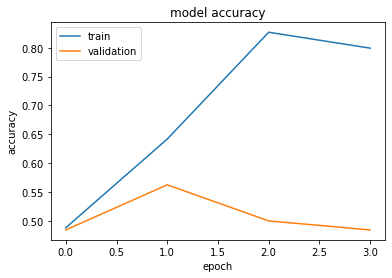

In [42]:
plot_hist(history)

In [43]:
results_nn = model.evaluate(nn_test_x, nn_test_y)
results_nn

3/3 [==============================] - 0s 10ms/step - loss: 1.1199 - accuracy: 0.5375


[1.119899034500122, 0.5375000238418579]

In [44]:
nn_preds = model.predict(nn_test_x)

In [45]:
from sklearn import metrics
nn_matrix = metrics.confusion_matrix(nn_test_y, nn_preds.argmax(axis=1))

In [46]:
nn_matrix

array([[36,  0,  7],
       [14,  1,  5],
       [11,  0,  6]], dtype=int64)

In [47]:
nn_accuracy = (nn_matrix[0][0]+nn_matrix[1][1]+nn_matrix[2][2])/nn_matrix.sum()

In [48]:
nn_precision = metrics.precision_score(nn_test_y, nn_preds.argmax(axis=1), average='macro')

In [49]:
nn_recall = metrics.recall_score(nn_test_y, nn_preds.argmax(axis=1), average='macro')

In [50]:
nn_f1score = metrics.f1_score(nn_test_y, nn_preds.argmax(axis=1), average = 'macro')

In [51]:
nn_auc = roc_auc_score_multiclass(nn_test_y, nn_preds.argmax(axis=1))

## K Nearest Neighbors

In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x, train_y)

KNeighborsClassifier(n_neighbors=3)

In [53]:
knn_preds = knn.predict(test_x)

In [54]:
knn_results = metrics.confusion_matrix(test_y, knn_preds)
knn_results

array([[31,  3,  9],
       [11,  1,  8],
       [11,  0,  6]], dtype=int64)

In [55]:
knn_accuracy = (knn_results[0][0]+knn_results[1][1]+knn_results[2][2])/knn_results.sum()

In [56]:
knn_precision = metrics.precision_score(test_y, knn_preds, average='macro')

In [57]:
knn_recall = metrics.recall_score(test_y, knn_preds, average='macro')

In [58]:
knn_f1score = metrics.f1_score(test_y, knn_preds, average = 'macro')

In [59]:
knn_auc = roc_auc_score_multiclass(test_y, knn_preds)

## Random Forest Classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(500, max_depth=4, class_weight={0: zero_class, 1: one_class, 2: two_class})
rf.fit(train_x, train_y)

RandomForestClassifier(class_weight={0: 0.5125786163522013,
                                     1: 0.1918238993710692,
                                     2: 0.29559748427672955},
                       max_depth=4, n_estimators=500)

In [61]:
rf_preds = rf.predict(test_x)

In [62]:
rf_results = metrics.confusion_matrix(test_y, rf_preds)
rf_results

array([[42,  0,  1],
       [18,  0,  2],
       [16,  0,  1]], dtype=int64)

In [63]:
rf_accuracy = (rf_results[0][0]+rf_results[1][1]+rf_results[2][2])/rf_results.sum()

In [64]:
rf_precision = metrics.precision_score(test_y, rf_preds, average='macro')

C:\Users\Katie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
rf_recall = metrics.recall_score(test_y, rf_preds, average='macro')

In [66]:
rf_f1score = metrics.f1_score(test_y, rf_preds, average = 'macro')

In [67]:
rf_auc = roc_auc_score_multiclass(test_y, rf_preds)

## Gradient Boosting

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate=.01, n_estimators=200,
                                #class_weight={0: zero_class, 1: one_class, 2: two_class},
                                validation_fraction=.2, n_iter_no_change=20)

In [69]:
gb.fit(train_x, train_y)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200,
                           n_iter_no_change=20, validation_fraction=0.2)

In [70]:
gb_preds = gb.predict(test_x)

In [71]:
gb_results = metrics.confusion_matrix(test_y, gb_preds)
gb_results

array([[43,  0,  0],
       [20,  0,  0],
       [17,  0,  0]], dtype=int64)

In [72]:
gb_accuracy = (gb_results[0][0]+gb_results[1][1]+gb_results[2][2])/gb_results.sum()

In [73]:
gb_precision = metrics.precision_score(test_y, gb_preds, average='macro')

C:\Users\Katie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
gb_recall = metrics.recall_score(test_y, gb_preds, average='macro')

In [75]:
gb_f1score = metrics.f1_score(test_y, gb_preds, average = 'macro')

In [76]:
gb_auc = roc_auc_score_multiclass(test_y, gb_preds)

## Complement Naive Bayes

In [77]:
from sklearn.naive_bayes import ComplementNB

from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler()
cnb_train = scaler.fit_transform(train_x)
cnb_test = scaler.transform(test_x)

In [78]:
cnb = ComplementNB()
cnb.fit(cnb_train, train_y)

ComplementNB()

In [79]:
cnb_preds = cnb.predict(cnb_test)

In [80]:
cnb_results = metrics.confusion_matrix(test_y, cnb_preds)
cnb_results

array([[30,  1, 12],
       [11,  2,  7],
       [ 8,  0,  9]], dtype=int64)

In [81]:
cnb_accuracy = (cnb_results[0][0]+cnb_results[1][1]+cnb_results[2][2])/cnb_results.sum()

In [82]:
cnb_precision = metrics.precision_score(test_y, cnb_preds, average='macro')

In [83]:
cnb_recall = metrics.recall_score(test_y, cnb_preds, average='macro')

In [84]:
cnb_f1score = metrics.f1_score(test_y, cnb_preds, average = 'macro')

In [85]:
cnb_auc = roc_auc_score_multiclass(test_y, cnb_preds)

## Multinomial Naive Bayes

In [86]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(cnb_train, train_y)

MultinomialNB()

In [87]:
mnb_preds = clf.predict(test_x)

In [88]:
mnb_results = metrics.confusion_matrix(test_y, mnb_preds)
mnb_results

array([[41,  2,  0],
       [18,  2,  0],
       [15,  2,  0]], dtype=int64)

In [89]:
mnb_accuracy = (mnb_results[0][0]+mnb_results[1][1]+mnb_results[2][2])/mnb_results.sum()

In [90]:
mnb_precision = metrics.precision_score(test_y, mnb_preds, average='macro')

C:\Users\Katie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
mnb_recall = metrics.recall_score(test_y, mnb_preds, average='macro')

In [92]:
mnb_f1score = metrics.f1_score(test_y, mnb_preds, average = 'macro')

In [93]:
mnb_auc = roc_auc_score_multiclass(test_y, mnb_preds)

# Creating Bar Graph for Model Comparison

In [94]:
type(test_y)

list

In [95]:
count = 0
true_zeros = sum([count + 1 for item in test_y if item == 0])

In [96]:
count = 0
true_ones = sum([count + 1 for item in test_y if item == 1])

In [97]:
count = 0
true_twos = sum([count + 1 for item in test_y if item == 2])

In [98]:
svm_zeros = results_svm[0][0] + results_svm[1][0] + results_svm[2][0]
svm_ones = results_svm[0][1] + results_svm[1][1] + results_svm[2][1]
svm_twos = results_svm[0][2] + results_svm[1][2] + results_svm[2][2]

In [99]:
nn_zeros = nn_matrix[0][0] + nn_matrix[1][0] + nn_matrix[2][0]
nn_ones = nn_matrix[0][1] + nn_matrix[1][1] + nn_matrix[2][1]
nn_twos = nn_matrix[0][2] + nn_matrix[1][2] + nn_matrix[2][2]

In [100]:
knn_zeros = knn_results[0][0] + knn_results[1][0] + knn_results[2][0]
knn_ones = knn_results[0][1] + knn_results[1][1] + knn_results[2][1]
knn_twos = knn_results[0][2] + knn_results[1][2] + knn_results[2][2]

In [101]:
rf_zeros = rf_results[0][0] + rf_results[1][0] + rf_results[2][0]
rf_ones = rf_results[0][1] + rf_results[1][1] + rf_results[2][1]
rf_twos = rf_results[0][2] + rf_results[1][2] + rf_results[2][2]

In [102]:
gb_zeros = gb_results[0][0] + gb_results[1][0] + gb_results[2][0]
gb_ones = gb_results[0][1] + gb_results[1][1] + gb_results[2][1]
gb_twos = gb_results[0][2] + gb_results[1][2] + gb_results[2][2]

In [103]:
cnb_zeros = cnb_results[0][0] + cnb_results[1][0] + cnb_results[2][0]
cnb_ones = cnb_results[0][1] + cnb_results[1][1] + cnb_results[2][1]
cnb_twos = cnb_results[0][2] + cnb_results[1][2] + cnb_results[2][2]

In [104]:
mnb_zeros = mnb_results[0][0] + mnb_results[1][0] + mnb_results[2][0]
mnb_ones = mnb_results[0][1] + mnb_results[1][1] + mnb_results[2][1]
mnb_twos = mnb_results[0][2] + mnb_results[1][2] + mnb_results[2][2]

In [105]:
labels = ["Incorrect", "Contextual", "Correct"]

true_counts = [true_zeros, true_ones, true_twos]
svm_counts = [svm_zeros, svm_ones, svm_twos]
nn_counts = [nn_zeros, nn_ones, nn_twos]
knn_counts = [knn_zeros, knn_ones, knn_twos]
rf_counts = [rf_zeros, rf_ones, rf_twos]
gb_counts = [gb_zeros, gb_ones, gb_twos]
cnb_counts = [cnb_zeros, cnb_ones, cnb_twos]
mnb_counts = [mnb_zeros, mnb_ones, mnb_twos]

<Figure size 1080x720 with 0 Axes>

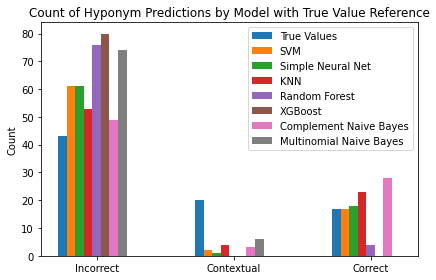

In [133]:
x = np.arange(len(labels))
width = .25

plt.figure(figsize=(15,10))

fig, ax = plt.subplots()
rects0 = ax.bar(x-width, true_counts, width/4, label="True Values")
rects1 = ax.bar(x-3*width/4, svm_counts, width/4, label="SVM")
rects2 = ax.bar(x-2*width/4, nn_counts, width/4, label="Simple Neural Net")
rects3 = ax.bar(x-width/4, knn_counts, width/4, label="KNN")
rects4 = ax.bar(x, rf_counts, width/4, label="Random Forest")
rects5 = ax.bar(x+width/4, gb_counts, width/4, label="XGBoost")
rects6 = ax.bar(x+2*width/4, cnb_counts, width/4, label="Complement Naive Bayes")
rects7 = ax.bar(x+3*width/4, mnb_counts, width/4, label="Multinomial Naive Bayes")

ax.set_ylabel("Count")
ax.set_title("Count of Hyponym Predictions by Model with True Value Reference")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig("hyponym_te.png")

plt.show()

# Creating Table for Paper

In [107]:
import dataframe_image as dfi

In [108]:
models = ["SVM", "Simple Neural Net", "KNN", "Random Forest", "XGBoost",
          "Complement Naive Bayes", "Multinomial Naive Bayes"]
all_results = {"Accuracy": [svm_accuracy, nn_accuracy, knn_accuracy, rf_accuracy,
                            gb_accuracy, cnb_accuracy, mnb_accuracy], 
               "Precision": [svm_precision, nn_precision, knn_precision,
                             rf_precision, gb_precision, cnb_precision, mnb_precision],
               "Recall": [svm_recall, nn_recall, knn_recall, rf_recall,
                          gb_recall, cnb_recall, mnb_recall],
               "Incorrect Precision": [svm_auc[0], nn_auc[0], knn_auc[0], rf_auc[0],
                                  gb_auc[0], cnb_auc[0], mnb_auc[0]],
               "Contextual Precision": [svm_auc[1], nn_auc[1], knn_auc[1], rf_auc[1],
                                  gb_auc[1], cnb_auc[1], mnb_auc[1]],
               "Correct Precision": [svm_auc[2], nn_auc[2], knn_auc[2], rf_auc[2],
                                  gb_auc[2], cnb_auc[2], mnb_auc[2]],
               "F1 Score": [svm_f1score, nn_f1score, knn_f1score, rf_f1score, 
                            gb_f1score, cnb_f1score, mnb_f1score]}

In [109]:
results_df = pd.DataFrame(all_results, index=models)
results_df = results_df.round(3)
results_df.head()

,Accuracy,Precision,Recall,Incorrect Precision,Contextual Precision,Correct Precision,F1 Score
SVM,0.625,0.562,0.503,0.681,0.517,0.701,0.463
Simple Neural Net,0.538,0.641,0.413,0.581,0.525,0.581,0.377
KNN,0.475,0.365,0.375,0.563,0.500,0.542,0.343
Random Forest,0.538,0.268,0.345,0.529,0.500,0.506,0.267
XGBoost,0.538,0.179,0.333,0.500,0.500,0.500,0.233


In [110]:
results_df.dfi.export('hyponym_results.png')

# Hyponym SME Results

In [111]:
sme_results = pd.read_excel("extracted_terms_3_28 - gc edits.xlsx", sheet_name="hyponyms")

In [112]:
sme_results.head()

,proposed\nlabel,Manual\nScore,hyponym,hypernym,Unnamed: 4
0,0,NaN,the proper process,supervisory and management official on discipl...,NaN
1,0,NaN,procedure,supervisory and management official on discipl...,NaN
2,0,NaN,a write reprimand,a formal disciplinary action,NaN
3,0,NaN,reference to previous counseling,the reason for selection of the penalty,NaN
4,0,NaN,disciplinary action,the reason for selection of the penalty,NaN


In [113]:
sme_results.drop("Unnamed: 4", inplace=True, axis=1)

In [114]:
sme_results.head()

,proposed\nlabel,Manual\nScore,hyponym,hypernym
0,0,NaN,the proper process,supervisory and management official on discipl...
1,0,NaN,procedure,supervisory and management official on discipl...
2,0,NaN,a write reprimand,a formal disciplinary action
3,0,NaN,reference to previous counseling,the reason for selection of the penalty
4,0,NaN,disciplinary action,the reason for selection of the penalty


In [115]:
sme_results = sme_results.dropna()
sme_results.head()

,proposed\nlabel,Manual\nScore,hyponym,hypernym
6,0,2.0,a union representative,representative
13,0,2.0,badge,dod identification
15,2,0.0,the concealment,information
16,2,0.0,removal,information
25,0,2.0,harassment,the offense


In [116]:
sme_results.loc[:, "Manual\nScore"] = sme_results["Manual\nScore"].astype(int, copy=False)

In [117]:
sme_results.head()

,proposed\nlabel,Manual\nScore,hyponym,hypernym
6,0,2,a union representative,representative
13,0,2,badge,dod identification
15,2,0,the concealment,information
16,2,0,removal,information
25,0,2,harassment,the offense


In [118]:
sme_results["Manual\nScore"].value_counts()

2    57
0    42
1    14
Name: Manual\nScore, dtype: int64

In [119]:
sme_matrix = metrics.confusion_matrix(sme_results["Manual\nScore"], sme_results["proposed\nlabel"])

In [120]:
sme_matrix

array([[ 0,  6, 36],
       [13,  0,  1],
       [55,  0,  2]], dtype=int64)

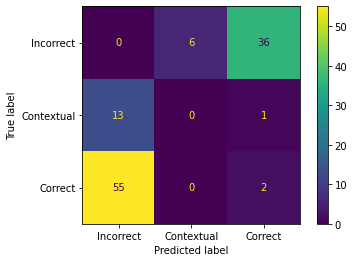

In [121]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sme_matrix,
                                      display_labels=["Incorrect", "Contextual", "Correct"])
disp.plot()

plt.savefig("hyponym_cm.png")
plt.show()

# Saving SVM Unlabeled Results to CSV

In [122]:
unlabeled_x = []
indices = []

for i in range(len(unlabeled_set)-1):
    try:
        unlabeled_x.append(list(model[unlabeled_set.iloc[i,0]]) + list(model[unlabeled_set.iloc[i,1]]))
        indices.append(i)
    except:
        # Check if the first word has more than one word
        if len(unlabeled_set.iloc[i,0].split()) > 1:
            # If so, average the word embedding arrays
            word_list1 = unlabeled_set.iloc[i,0].split()
            try:
                vector_array1 = np.array([list(model[word]) for word in word_list1])
                final_array1 = list(np.average(vector_array1, axis=0))
            except:
                vector_list1 = []
                for word in word_list1:
                    try:
                        vector_list1.append(model[word])
                    except:
                        vector_list1.append(np.full(200, .001))
                vector_array1 = np.array(vector_list1)
                final_array1 = list(np.average(vector_array1, axis=0))
        else:
            # Otherwise, try to take the embedding as is
            try:
                final_array1 = list(model[unlabeled_set.iloc[i,0]])
            except:
                continue
        # Check if the second word has more than one word
        if len(unlabeled_set.iloc[i,1].split()) > 1:
            # If so, average the word embedding arrays
            word_list2 = unlabeled_set.iloc[i,1].split()
            try:
                vector_array2 = np.array([list(model[word]) for word in word_list2])
                final_array2 = list(np.average(vector_array2, axis=0))
            except:
                vector_list2 = []
                for word in word_list2:
                    try:
                        vector_list2.append(model[word])
                    except:
                        vector_list2.append(np.full(200, .001))
                vector_array2 = np.array(vector_list2)
                final_array2 = list(np.average(vector_array2, axis=0))
        else:
            # Otherwise, try to take the embedding as is
            try:
                final_array2 = list(model[unlabeled_set.iloc[i,1]])
            except:
                continue
        
        unlabeled_x.append(final_array1 + final_array2)
        indices.append(i)

In [123]:
len(unlabeled_x)

6710

In [124]:
unlabeled_preds = SVM.predict(unlabeled_x)

In [125]:
proposed_labeled_hyponyms = unlabeled_set.iloc[indices,:]
len(proposed_labeled_hyponyms)

6710

In [126]:
proposed_labeled_hyponyms["proposed_label"] = unlabeled_preds

C:\Users\Katie\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [127]:
proposed_labeled_hyponyms.head()

,hyponym,hypernym,proposed_label
0,the proper process,supervisory and management official on discipl...,2.0
2,a write reprimand,a formal disciplinary action,2.0
3,reference to previous counseling,the reason for selection of the penalty,2.0
4,disciplinary action,the reason for selection of the penalty,2.0
12,lending identification card,dod identification,2.0


In [128]:
len(proposed_labeled_hyponyms[proposed_labeled_hyponyms["proposed_label"] == 2])

6710

In [129]:
len(proposed_labeled_hyponyms[proposed_labeled_hyponyms["proposed_label"] == 1])

0

In [130]:
len(proposed_labeled_hyponyms[proposed_labeled_hyponyms["proposed_label"] == 0])

0

In [131]:
proposed_labeled_hyponyms[proposed_labeled_hyponyms["proposed_label"] == 2].sample(10)

,hyponym,hypernym,proposed_label
2120,pre adoptive child,dependent child,2.0
13299,board certification,professional qualification,2.0
6527,support staff,service member to gme program,2.0
12968,the dod cover entity,surgeon general of the navy,2.0
10890,biological agents,toxicological agents,2.0
2403,civil right organization,local community resource,2.0
9117,electrical connection,external difference,2.0
11325,canvas mail sack,excess mte,2.0
4762,foreign military aircraft,lawful use of airspace under international law...,2.0
5986,information sharing,ditmac activity,2.0


In [132]:
proposed_labeled_hyponyms.to_csv("proposed_hyponym_labelsv2.csv")